# Tabular Playground Series 7 - Predict Air Pollution

The dataset deals with predicting air pollution in a city via various input sensor values. The task is to predict, based on the sensor, values **three** target variables: target_carbon_monoxide,target_benzene and target_nitrogen_oxides. Submissions are evaluated using the [mean column-wise root mean squared logarithmic error](http://www.kaggle.com/c/tabular-playground-series-jul-2021/overview/evaluation).

In this notebook I experimented with a pure time series algorithm: **Prophet**, developed by Facebook. [Prophed is described as](http://facebook.github.io/prophet/):
<div class="alert alert-success">
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
</div>

I use Prophet to predict the three target variables seperately and assess the performance on the training data. Using visual checks it can be seen how Prophet works and that **it is not able to learn the training data as well as XGBoost** that I used in [my other notebook](https://www.kaggle.com/melanie7744/tps7-tuned-xgb-graphic-validation/notebook?scriptVersionId=69040682&select=submission_xgb_minfactor.csv).
This is not very surprising given the fact that Prophet only uses the timestamp and the target variable for it's predictions whereas XGBoost can make use of all features.


Feedback is highly appreciated!


### Note: I decided not to use the leak!


In [1]:
# install prophet
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 299 kB/s 
     |████████████████████████████████| 49 kB 925 kB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6644987 sha256=ff640cbdbe6502075a8c1459418c6bef246303211e461a7e91da5e4bd80c4561
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly
import plotly.express as px
import plotly.graph_objects as go
print("plotly version: {}". format(plotly.__version__))

from prophet import Prophet
#print('Prophet Version: %s' % prophet.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


plotly version: 5.1.0
/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [3]:
# read input files
df_train = pd.read_csv("../input/tabular-playground-series-jul-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-jul-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv")

In [4]:
# store target columns
y_cm = df_train["target_carbon_monoxide"]
y_b = df_train["target_benzene"]
y_no = df_train["target_nitrogen_oxides"]
target_cols = ["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]
# store known target values
known_target = df_train.iloc[7110][target_cols]

In [5]:
df_train['date_time'] = pd.to_datetime(df_train['date_time'])
df_train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


## Target Carbon Monoxide: Train, predict and assess performance

In [6]:
# get the training data in the format needed by Prophet
df = df_train[['date_time','target_carbon_monoxide']].copy()
df.columns = ["ds","y"] # Prophet requires special column names
display(df.head())

param_grid = { # only used to note down my hyperparameter tuning experiments
    'changepoint_prior_scale' : [0.001], # a higher value here makes the predictions follow the yearly trend more closely
    'seasonality_prior_scale' : [0.01 , 10], # with visual inspection I could not see the effect of this parameter, so let's keep the default (10)
    'changepoint_range' : [0.7, 0.8, 0.9] # setting it to 0.9 will make predictions go down at the end, keep default 0.8
}

# fit model
model = Prophet(changepoint_prior_scale = 0.1 )
model.fit(df)

,ds,y
0,2010-03-10 18:00:00,2.5
1,2010-03-10 19:00:00,2.1
2,2010-03-10 20:00:00,2.2
3,2010-03-10 21:00:00,2.2
4,2010-03-10 22:00:00,1.5


In [7]:
# prepare test set, Prophet requires a dataframe with one column named "ds" containing timestamps
# by default, make_future_dataframe includes historic dates as well to be able to see the fit
timerange = model.make_future_dataframe(periods=2246, freq='H')

In [8]:
# make predictions for training data + test data to assess how good Prophet got the trends
predictions = model.predict(timerange)
# if there are negative predictions, set them to 0
predictions.yhat = np.clip(predictions.yhat,0,None)
# calculate training rmsle, use yhat
train_pred = predictions.iloc[:df_train.shape[0]]
train_rmsle = (((np.log(train_pred.yhat + 1) - np.log(df.y + 1))**2).sum() / train_pred.shape[0] )**0.5
print("Training rmsle: ", train_rmsle)
# store predictions for test set
test_pred_y_cm = predictions.iloc[df_train.shape[0]-1:]

Training rmsle:  0.3122302761778634


In [9]:
predictions.head(2)
# the prediction from Prophet gives a lot of values, including confidence intervals for the predictions 
# the actual prediction (yhat) is at the end

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-03-10 18:00:00,2.537847,2.636479,5.378753,2.537847,2.537847,1.471403,1.471403,1.471403,1.299805,1.299805,1.299805,0.171598,0.171598,0.171598,0.0,0.0,0.0,4.009250
1,2010-03-10 19:00:00,2.536840,2.868610,5.489910,2.536840,2.536840,1.645413,1.645413,1.645413,1.474112,1.474112,1.474112,0.171301,0.171301,0.171301,0.0,0.0,0.0,4.182252


In [10]:
# plot
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=timerange.ds, 
                 y=y_cm, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 #opacity=0.1,
                 name="Carbon Monoxide Ground Truth")
)
fig.add_trace(
      go.Scatter(x=timerange.ds, 
                 y=predictions.yhat, 
                 mode = 'lines', 
                 line = {'color':'black', 'width' : 1},
                 #opacity=0.1,
                 name="Carbon Monoxide Predicted")
)

fig.update_layout(
    title="Carbon Monoxide Predicted vs Ground Truth (train data)"
)
fig.show()

It can be seen how Prophet detects seasonal components in the training data and builds it's predictions based on them. Don't forget to zoom in!

## Target Benzene: Train, predict and assess performance

In [11]:
# get the training data in the format needed by Prophet
df = df_train[['date_time','target_benzene']].copy()
df.columns = ["ds","y"]
#df.head()

param_grid = { # only to note down my hyperparameter tuning experiments
    'changepoint_prior_scale' : [0.001, 1], # 1 makes test predictions go down steadily
    'seasonality_prior_scale' : [0.01 , 10], # with visual inspection I could not see the effect of this parameter, so let's keep the default (10)
    'changepoint_range' : [0.7, 0.8, 0.9] # setting it to 0.9 will make predictions go down at the end, keep default 0.8
}

# fit model
model = Prophet(changepoint_prior_scale = 0.001, changepoint_range = 0.9 )
model.fit(df)

# make predictions for training data + test data to assess how good Prophet got the trends
predictions = model.predict(timerange)
# if there are negative predictions, set them to 0
predictions.yhat = np.clip(predictions.yhat,0,None)
# calculate training rmsle, use yhat
train_pred = predictions.iloc[:df_train.shape[0]]
train_rmsle = (((np.log(train_pred.yhat + 1) - np.log(df.y + 1))**2).sum() / train_pred.shape[0] )**0.5
print("Training rmsle: ", train_rmsle)
# store predictions for test set
test_pred_y_b = predictions.iloc[df_train.shape[0]-1:]

Training rmsle:  0.6847068280978831


In [12]:
# plot
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=timerange.ds, 
                 y=y_b, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 #opacity=0.1,
                 name="Benzene Ground Truth")
)
fig.add_trace(
      go.Scatter(x=timerange.ds, 
                 y=predictions.yhat, 
                 mode = 'lines', 
                 line = {'color':'black', 'width' : 1},
                 #opacity=0.1,
                 name="Benzene Predicted")
)

fig.update_layout(
    title="Benzene Predicted vs Ground Truth (train data)"
)
fig.show()

## Nitrogen Oxides: Train, predict and assess performance

In [13]:
# get the training data in the format needed by Prophet
df = df_train[['date_time','target_nitrogen_oxides']].copy()
df.columns = ["ds","y"]
#df.head()

param_grid = { # only to note down my hyperparameter tuning experiments
    'changepoint_prior_scale' : [0.01, 1, 10], # 0.01 makes test predictions go up steadily, 1/10 make them go down slightly
    'seasonality_prior_scale' : [0.01 , 10], # with visual inspection I could not see the effect of this parameter, so let's keep the default (10)
    'changepoint_range' : [0.7, 0.8, 0.9] # setting it to 0.9 will make predictions go down at the end, keep default 0.8
}

# fit model
model = Prophet(changepoint_prior_scale = 1)
model.fit(df)

# make predictions for training data + test data to assess how good Prophet got the trends
predictions = model.predict(timerange)
# if there are negative predictions, set them to 0
predictions.yhat = np.clip(predictions.yhat,0,None)
# calculate training rmsle, use yhat
train_pred = predictions.iloc[:df_train.shape[0]]
train_rmsle = (((np.log(train_pred.yhat + 1) - np.log(df.y + 1))**2).sum() / train_pred.shape[0] )**0.5
print("Training rmsle: ", train_rmsle)
# store predictions for test set
test_pred_y_no = predictions.iloc[df_train.shape[0]-1:]

Training rmsle:  1.1408064113527734


In [14]:
# plot
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=timerange.ds, 
                 y=y_no, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 #opacity=0.1,
                 name="Nitrogen Oxides Ground Truth")
)
fig.add_trace(
      go.Scatter(x=timerange.ds, 
                 y=predictions.yhat, 
                 mode = 'lines', 
                 line = {'color':'black', 'width' : 1},
                 #opacity=0.1,
                 name="Nitrogen Oxides Predicted")
)

fig.update_layout(
    title="Nitrogen Oxides Predicted vs Ground Truth (train data)"
)
fig.show()

### Examining Prophet's build in plotting possibilities

I use Nitrogen Oxides here as an example. It can be seen how the confidence of the model in it's predictions decreases with a rising time horizon. In other words, the farther a prediction is away from the training data, the more unsure the model is.

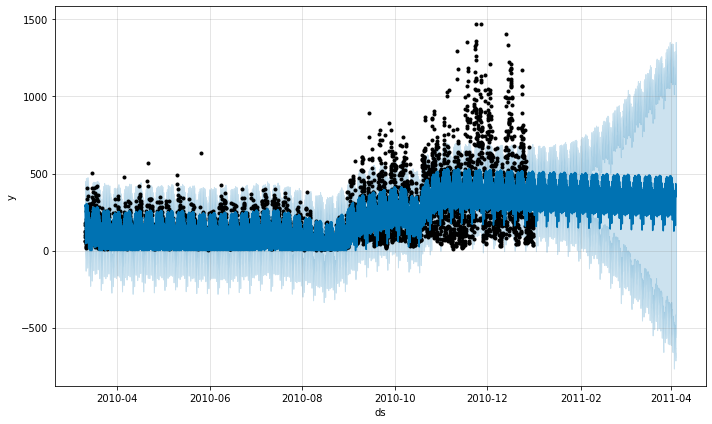

In [15]:
# prophet build in plotting, shows the confidence intervals, but overall gives me less insight than the plotly graphic
fig = model.plot(predictions)

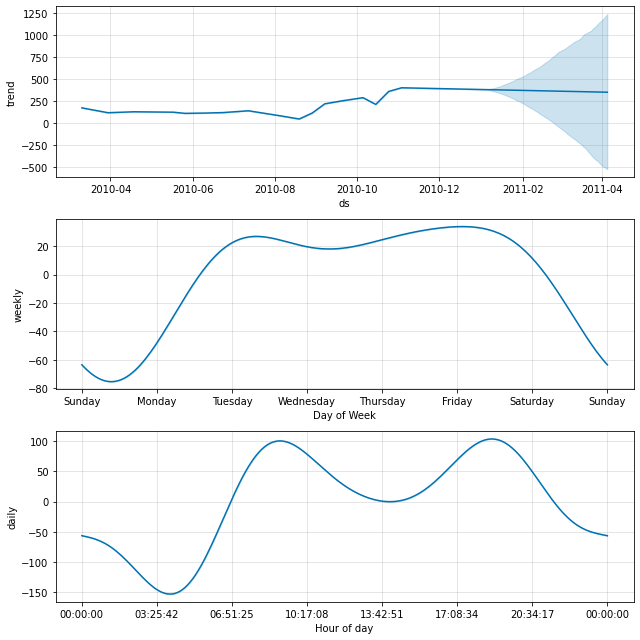

In [16]:
# prophet build in plotting, shows compontents of the prediction
fig = model.plot_components(predictions)

# Submission


In [17]:
# generate submission file 
submission_prophet = pd.DataFrame(data={"date_time" : sample_submission.date_time,
                               "target_carbon_monoxide" : test_pred_y_cm.yhat.values,
                               "target_benzene" : test_pred_y_b.yhat.values,
                               "target_nitrogen_oxides" : test_pred_y_no.yhat.values})
submission_prophet.loc[0,target_cols] = known_target # replace the first row with the known values as timestamp is identical
submission_prophet.to_csv('submission_prophet.csv', index=False)
submission_prophet.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.046695,7.864554,321.860052
2,2011-01-01 02:00:00,1.687243,5.966109,291.238193
3,2011-01-01 03:00:00,1.163310,3.326651,251.354443
4,2011-01-01 04:00:00,0.837481,1.941267,228.747353
